In [2]:
import numpy as np
from scipy import integrate
from scipy.stats import lognorm
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import pandas as pd
import datetime
import sys
sys.path.append("..")
from RiskPackage.CalculateReturn import return_calculate
from RiskPackage.RiskMetrics import RiskMetrics
import statsmodels.api as sm
sns.set_theme()

# Problem 1
Assume you a call and a put option with the following
- Current Stock Price $165
- Current Date 03/03/2023
- Options Expiration Date 03/17/2023
- Risk Free Rate of 4.25%
- Continuously Compounding Coupon of 0.53%

Calculate the time to maturity using calendar days (not trading days).
For a range of implied volatilities between 10% and 80%, plot the value of the call and the put.
Discuss these graphs. How does the supply and demand affect the implied volatility?


In [3]:
def integral_gbsm(s,strike,t,vol,rf,c,tradingDayYear,call=True):
    '''
    Option valuation via integral -- Generalized Black Scholes Merton
    European Style.  Assumed LogNormal Prices
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency

    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    call - Call valuation if set True
    '''

    ttm = t/tradingDayYear # time to maturity
    dailyVol = vol/np.sqrt(tradingDayYear) # daily volatility
    sigma = dailyVol*np.sqrt(t)
    mu = np.log(s)+ttm*c-sigma**2/2 

    dist = lognorm(sigma,0,np.exp(mu))
    f = lambda x: 2*dist.pdf(x)

    if call:
        f = lambda x: max(x-strike,0) * dist.pdf(x)
        value = np.exp(-ttm*rf)*integrate.quad(f,0,strike*100)[0]
    else:
        f = lambda x: max(strike-x,0)*dist.pdf(x)
        value = np.exp(-ttm*rf)*integrate.quad(f,0,strike*100)[0]
    return value


    # lognormal of numpy is a liitle bit strange. 

    # In mathematical notation if X is N(mu,sigma) then Y=exp(X) is LogN(mu, sigma). To get X in scipy I would use norm(mu,sigma) but to get Y I would use lognorm(sigma, 0, exp(mu))

    # X = exp(mu + sigma * Z), Z is standard normal
    # which is the same as: X = exp(mu) * exp(Z)**sigma      
    # This can be sneakily re-written as follows: X = exp(mu) * exp(Z-Z0)**sigma where Z0 = 0
    # This equation is of the form: f(x) = a * ( (x-x0) ** b ) = scale * ( (x-location) ** shape )

    '''
    Problem: 
    we could directly use np.inf as upper bound because the quad would generate wrong result.
    
    Solutions and explanations:
    For quad, be aware that pulse shapes and other sharp features as compared to the size of the integration interval may not be integrated correctly using this method. 
    For example, the function is using only two (last=2) intervals. You can add points to the interval to force the routine to use points closer to the left limit. Note that points is a sequence of break points in the bounded integration interval where local difficulties of the integrand may occur (e.g., singularities, discontinuities). In this case, I'm not using it to point out discontinuities, but rather to force quad to perform more integration steps near the left boundary.
    quad use heuristic algorithms, using adaptative step of integration to reduce time computing. Where the function is flat, it goes faster. so on big global interval, it can miss the peak.
    This happens because the adaptive quadrature routine implemented in quad, while working as designed, does not notice the small, important part of the function within such a large, finite interval. For best results, consider using integration limits that tightly surround the important part of the integrand.
    Integrands with several important regions can be broken into pieces as necessary.
    '''

In [4]:
def gbsm(s,strike,t,vol,rf,c,tradingDayYear,call=True):
    '''
    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency

    Option valuation via BSM closed formula
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    call - Call valuation if set True
    '''
    ttm=t/tradingDayYear
    d1=(np.log(s/strike)+(c+vol**2/2)*ttm)/vol/np.sqrt(ttm)
    d2=d1-vol*np.sqrt(ttm)
    if call:
        return s*np.exp((c-rf)*ttm)*norm.cdf(d1)-strike*np.exp(-rf*ttm)*norm.cdf(d2)
    else:
        return strike*np.exp(-rf*ttm)*norm.cdf(-d2)-s*np.exp((c-rf)*ttm)*norm.cdf(-d1)

In [4]:
def binomial_tree_gbsm(s,strike,t,vol,rf,c,tradingDayYear,N,call=True):
    '''
    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency

    Option valuation via Binomial Trees
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    N - Steps of Binomial Tree
    call - Call valuation if set True
    '''
    ttm=t/tradingDayYear
    delta_t=ttm/N
    # price multiplier in the (positive, negtive) case
    u=np.exp(vol*np.sqrt(delta_t)) 
    d=np.exp(-vol*np.sqrt(delta_t))
    # probability of up/down move in price
    pu=(np.exp(c*delta_t)-d)/(u-d)
    pd=1-pu
    S=[] # stock price
    P=[] # probability of each case
    nPaths=[] # number of paths of each case
    for i in range(N+1):
        S.append(s*(u**i)*(d**(N-i)))
        P.append((pu**i)*(pd**(N-i)))
        nPaths.append(math.factorial(N)/math.factorial(i)/math.factorial(N-i))
    # turn list into array
    S=np.array(S)
    P=np.array(P)
    nPaths=np.array(nPaths)
    # function to convert stock price to value of option
    f=lambda x,y: x-y if x-y>0 else 0
    vfunc = np.vectorize(f,otypes=[float])
    if call:
        Pi=vfunc(S,strike)
    else:
        Pi=vfunc(strike,S)
    return np.exp(-rf*ttm)*(Pi*P)@nPaths
    

In [6]:
def sim_gbsm(s,strike,t,vol,rf,c,tradingDayYear,N,call=True):
    '''
    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency

    Option valuation via Monte Simulation
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    N - Steps of Binomial Tree
    call - Call valuation if set True
    '''
    ttm = t/tradingDayYear # time to maturity
    dailyVol = vol/np.sqrt(tradingDayYear) # daily volatility
    dist=norm(c/tradingDayYear-dailyVol**2/2,dailyVol)
    Price=[]
    for i in range(N):
      rts=dist.rvs(t)
      total_rt=np.exp(sum(rts))
      Price.append(s*total_rt)
    f=lambda x,y: x-y if x-y>0 else 0
    vfunc = np.vectorize(f,otypes=[float])
    if call:
      Pi=vfunc(Price,strike)
    else:
      Pi=vfunc(strike,Price)
    return np.exp(-rf*ttm)*Pi.mean()

    

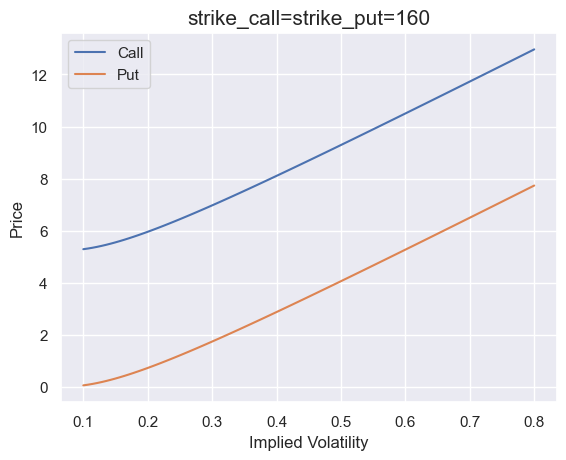

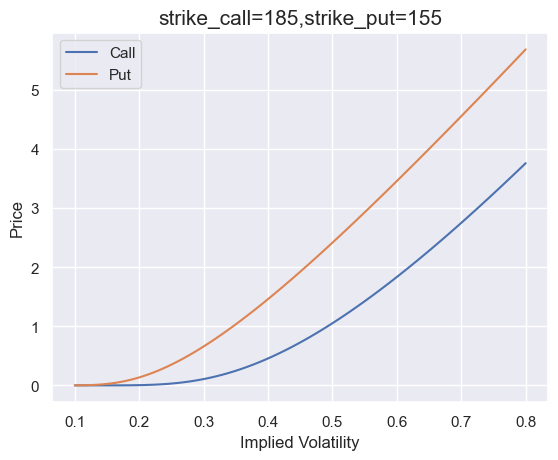

In [5]:
s=165
CurrentDate=datetime.datetime.strptime('03/03/2023','%m/%d/%Y')
ExpirationDate=datetime.datetime.strptime('03/17/2023','%m/%d/%Y')
dt=ExpirationDate-CurrentDate
t=dt.days
tradingDayYear=365
rf=0.0425
q=0.0053
c=rf-q
ttm=t/tradingDayYear
N=100 # number of points in range of volatility

# strike_call=strike_put=160
strike_call=strike_put=160
call_option_value=[]
put_option_value=[]
for vol in np.linspace(0.1,0.8,N):
    call_option_value.append(gbsm(s,strike_call,t,vol,rf,c,tradingDayYear,call=True))
    put_option_value.append(gbsm(s,strike_put,t,vol,rf,c,tradingDayYear,call=False))

plt.plot(np.linspace(0.1,0.8,N),call_option_value,label = "Call")
plt.plot(np.linspace(0.1,0.8,N),put_option_value,label = "Put")
plt.legend(loc='best')
plt.xlabel('Implied Volatility')
plt.ylabel('Price')
plt.title('strike_call=strike_put=160',{'fontsize':15})
plt.savefig("./image_1/strike_call=strike_put=160.png",dpi=600, bbox_inches='tight')
plt.show()



# strike_call=185, strike_put=155
strike_call=185
strike_put=155
call_option_value=[]
put_option_value=[]
for vol in np.linspace(0.1,0.8,N):
    call_option_value.append(gbsm(s,strike_call,t,vol,rf,c,tradingDayYear,call=True))
    put_option_value.append(gbsm(s,strike_put,t,vol,rf,c,tradingDayYear,call=False))

plt.plot(np.linspace(0.1,0.8,N),call_option_value,label = "Call")
plt.plot(np.linspace(0.1,0.8,N),put_option_value,label = "Put")
plt.legend(loc='best')
plt.xlabel('Implied Volatility')
plt.ylabel('Price')
plt.title('strike_call=185,strike_put=155',{'fontsize':15})
plt.savefig("./image/image_1/strike_call=185,strike_put=155.png",dpi=600, bbox_inches='tight')
plt.show()

# Problem 2
Use the options found in AAPL_Options.csv
- Current AAPL price is 151.03
- Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

Calculate the implied volatility for each option.\
Plot the implied volatility vs the strike price for Puts and Calls. Discuss the shape of these graphs. What market dynamics could make these graphs?\
There are bonus points available on this question based on your discussion\
Take some time to research if needed.

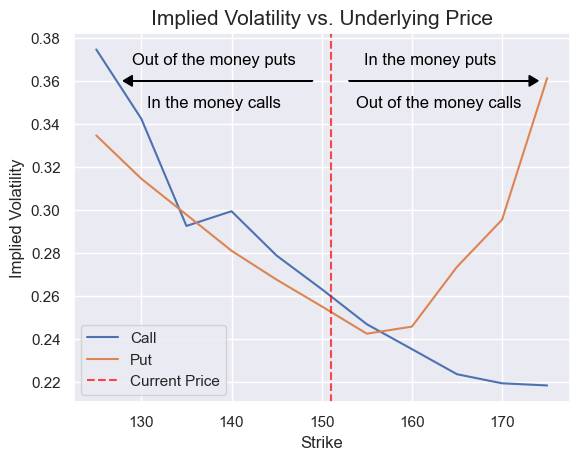

In [7]:
df=pd.read_csv('AAPL_Options.csv')

def findImpliedVol(data):
    '''
    Find implied volatility
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    N - Steps of Binomial Tree
    call - Call valuation if set True

    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency
    '''
    s=151.03
    strike=data['Strike']
    CurrentDate=datetime.datetime.strptime('03/03/2023','%m/%d/%Y')
    ExpirationDate=data['Expiration']
    ExpirationDate=datetime.datetime.strptime(ExpirationDate,'%m/%d/%Y')
    dt=ExpirationDate-CurrentDate
    t=dt.days
    tradingDayYear=365
    P=data['Last Price']
    call=True if data['Type']=='Call' else False
    rf=0.0425
    q=0.0053
    c=rf-q
    ttm=t/tradingDayYear
    def f(vol):
        return gbsm(s,strike,t,vol,rf,c,tradingDayYear,call)-P  
    iVol = optimize.root_scalar(f, bracket=[1e-6, 10], method='brentq')
    return iVol.root

currentPrice=151.03
iVol=df.apply(findImpliedVol,axis=1)
df['Implied Volatility']=iVol
df.sort_values('Strike',inplace=True)
ax=df.query("Type == 'Call'").plot(x='Strike',y='Implied Volatility',kind='line',xlabel='Strike',ylabel='Implied Volatility',label='Call')
df.query("Type == 'Put'").plot(x='Strike',y='Implied Volatility',kind='line',xlabel='Strike',ylabel='Implied Volatility',ax=ax,label='Put')
ax.axvline(currentPrice,color="red",alpha=0.7,linestyle='--',label='Current Price') # plot the vertical line of currentPrice
ax.arrow(149, 0.36, -20, 0, width=0.0001,head_width=0.005,head_length=1,color='black')
ax.arrow(153, 0.36, 20, 0, width=0.0001,head_width=0.005,head_length=1,color='black')
ax.text(138, 0.37, 'Out of the money puts', horizontalalignment='center',verticalalignment='center',color='black')
ax.text(138, 0.35, 'In the money calls', horizontalalignment='center',verticalalignment='center',color='black')
ax.text(162, 0.37, 'In the money puts', horizontalalignment='center',verticalalignment='center',color='black')
ax.text(163, 0.35, 'Out of the money calls', horizontalalignment='center',verticalalignment='center',color='black')
ax.legend()
ax.set_title('Implied Volatility vs. Underlying Price',{'fontsize':15})
plt.savefig("./image/image_2/ImpliedVolatility.png",dpi=600, bbox_inches='tight')
plt.show()


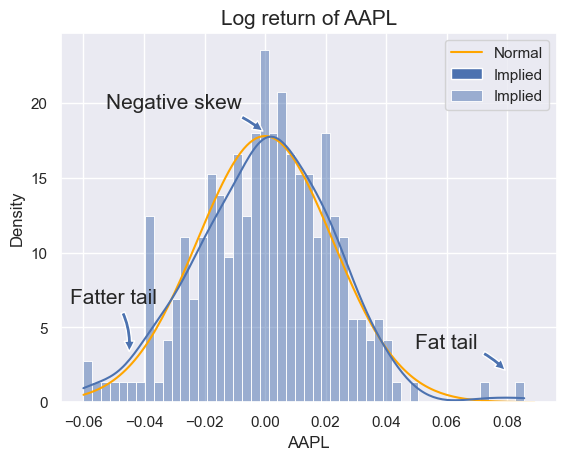

In [31]:
priceData=pd.read_csv('DailyPrices.csv',index_col='Date')
logReturn=return_calculate(priceData.AAPL,option="CONTINUOUS",rm_means=True)

vol=logReturn.std()
m=logReturn.mean()
x=np.arange(-0.06,0.09,1e-3)
y=norm.pdf(x, loc=m, scale=vol)

plt.plot(x,y,color='orange',label='Normal')
sns.histplot(data=logReturn,kde=True,stat="density",bins=50,label='Implied')
plt.annotate("Fat tail",
            xy=(0.08, 2), xycoords='data',
            xytext=(0.06, 4), textcoords='data',
            size=15, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),
            )

plt.annotate("Negative skew",
            xy=(0, 18), xycoords='data',
            xytext=(-0.03, 20), textcoords='data',
            size=15, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),
            )

plt.annotate("Fatter tail",
            xy=(-0.045, 3.2), xycoords='data',
            xytext=(-0.05, 7), textcoords='data',
            size=15, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),
            )

plt.legend()
plt.title('Log return of AAPL',{'fontsize':15})
plt.savefig("./image/image_2/logReturn.png",dpi=600, bbox_inches='tight')
plt.show()


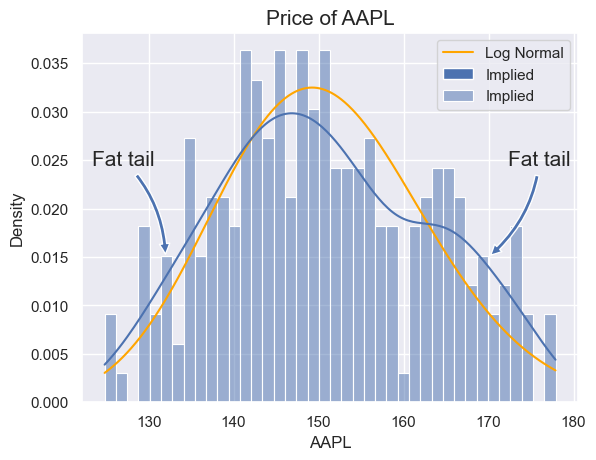

In [38]:
priceData=pd.read_csv('DailyPrices.csv',index_col='Date').AAPL

mod_params=lognorm.fit(priceData,floc=0)
x=np.arange(priceData.min(),priceData.max(),1e-3)
y=lognorm.pdf(x, mod_params[0], mod_params[1],mod_params[2])

plt.plot(x,y,color='orange',label='Log Normal')
sns.histplot(data=priceData,kde=True,stat="density",label='Implied',bins=40)
plt.annotate("Fat tail",
            xy=(170, 0.015), xycoords='data',
            xytext=(176, 0.025), textcoords='data',
            size=15, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),
            )
plt.annotate("Fat tail",
            xy=(132, 0.015), xycoords='data',
            xytext=(127, 0.025), textcoords='data',
            size=15, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2"),
            )
plt.legend()
plt.title('Price of AAPL',{'fontsize':15})
plt.savefig("./image/image_2/Price.png",dpi=600, bbox_inches='tight')
plt.show()

# Problem 3
Use the portfolios found in problem3.csv
- Current AAPL price is 151.03
- Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in the lecture.

Using DailyPrices.csv. Calculate the log returns of AAPL. Demean the series so there is 0 mean. Fit an
AR(1) model to AAPL returns. Simulate AAPL returns 10 days ahead and apply those returns to the
current AAPL price (above). Calculate Mean, VaR and ES. Discuss.\
Hints:
- you will need to calculate the implied volatility - might not be the same as #2
- you need to take into account the change in dates for option valuations. You are simulating
forward in time and options valuations are a function of time
- Calculate the PL from the current portfolio value using Current Date

In [39]:
# Calculate the implied volatility of each option
df=pd.read_csv('problem3.csv')

def findImpliedVol_plus(data):
    '''
    Find implied volatility
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    call - Call valuation if set True

    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency
    '''
    if data['Type']!='Option':
        return np.nan
    s=151.03
    strike=data['Strike']
    CurrentDate=datetime.datetime.strptime('03/03/2023','%m/%d/%Y')
    ExpirationDate=data['ExpirationDate']
    ExpirationDate=datetime.datetime.strptime(ExpirationDate,'%m/%d/%Y')
    dt=ExpirationDate-CurrentDate
    t=dt.days
    tradingDayYear=365
    P=data['CurrentPrice']
    call=True if data['OptionType']=='Call' else False
    rf=0.0425
    q=0.0053
    c=rf-q
    ttm=t/tradingDayYear
    def f(vol):
        return gbsm(s,strike,t,vol,rf,c,tradingDayYear,call)-P  
    iVol = optimize.root_scalar(f, bracket=[1e-6, 10], method='brentq')
    return iVol.root

iVol=df.apply(findImpliedVol_plus,axis=1)
df['Implied Volatility']=iVol

In [40]:
def gbsm_plus(data,prices,days=0):
    '''
    Generalize Black Scholes Merton
    rf = c       -- Black Scholes 1973
    c = rf - q   -- Merton 1973 stock model where q is the continous dividend yield
    c = 0        -- Black 1976 futures option model
    c,r = 0      -- Asay 1982 margined futures option model
    c = rf - rff -- Garman and Kohlhagen 1983 currency option model where rff is the risk free rate of the foreign currency

    Option valuation via BSM closed formula
    European Style.  Assumed LogNormal Prices
    s - Underlying Price
    strike - Strike Price
    t - days until maturity
    rf - Risk free rate
    vol - Yearly Volatility
    c - Cost of Carry
    tradingDayYear - trading days in a year
    call - Call valuation if set True
    '''
    if data['Type']!='Option':
        return prices*data['Holding']

    strike=data['Strike']
    CurrentDate=datetime.datetime.strptime('03/03/2023','%m/%d/%Y')+datetime.timedelta(days=days)
    ExpirationDate=data['ExpirationDate']
    ExpirationDate=datetime.datetime.strptime(ExpirationDate,'%m/%d/%Y')
    dt=ExpirationDate-CurrentDate
    t=dt.days
    tradingDayYear=365
    P=data['CurrentPrice']
    call=True if data['OptionType']=='Call' else False
    rf=0.0425
    q=0.0053
    c=rf-q
    ttm=t/tradingDayYear
    vol = data['Implied Volatility']

    positionValue=[]
    for s in prices:
        d1=(np.log(s/strike)+(c+vol**2/2)*ttm)/vol/np.sqrt(ttm)
        d2=d1-vol*np.sqrt(ttm)
        if call:
            positionValue.append(s*np.exp((c-rf)*ttm)*norm.cdf(d1)-strike*np.exp(-rf*ttm)*norm.cdf(d2))
        else:
            positionValue.append(strike*np.exp(-rf*ttm)*norm.cdf(-d2)-s*np.exp((c-rf)*ttm)*norm.cdf(-d1))
    # list can not times -1, convert to array
    positionValue = np.array(positionValue)
    return positionValue * data['Holding']

In [41]:
def calPayoff(data,prices):
    '''
    Calculate the payoff at expiration date according to different price
    '''
    if data['Type']!='Option':
        return prices*data['Holding']
    call=True if data['OptionType']=='Call' else False
    strike=data['Strike']
    payoff=[]
    for s in prices:
        if call:
            payoff.append(max(s-strike,0))
        else:
            payoff.append(max(strike-s,0))
    # list can not times -1, convert to array
    payoff = np.array(payoff)
    return payoff * data['Holding']

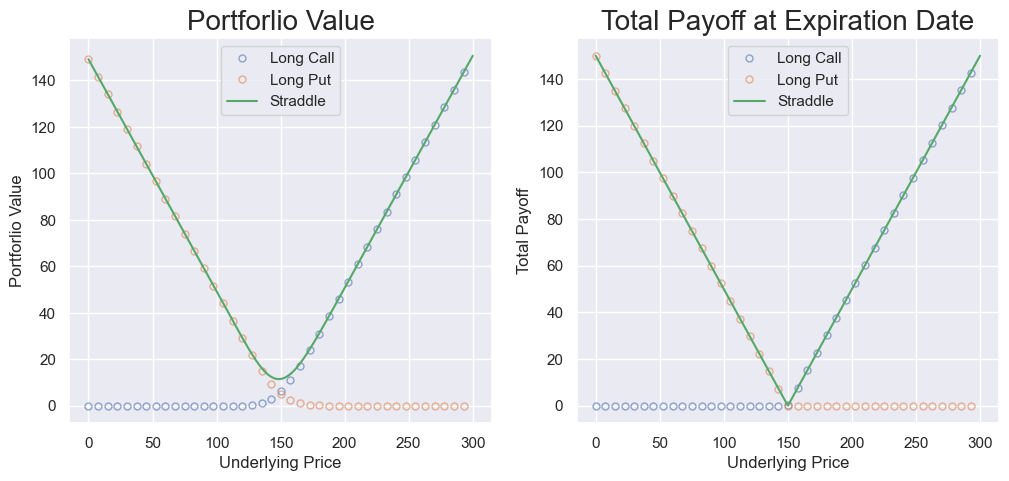

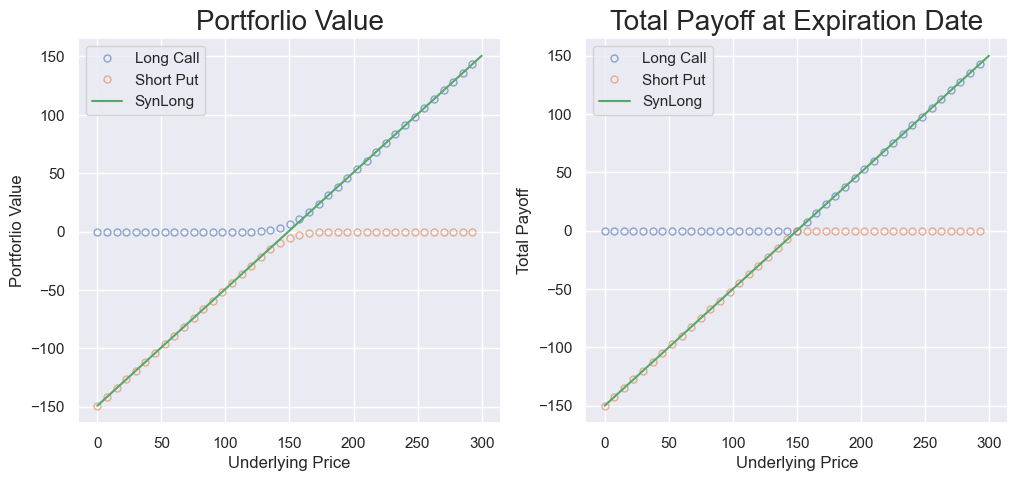

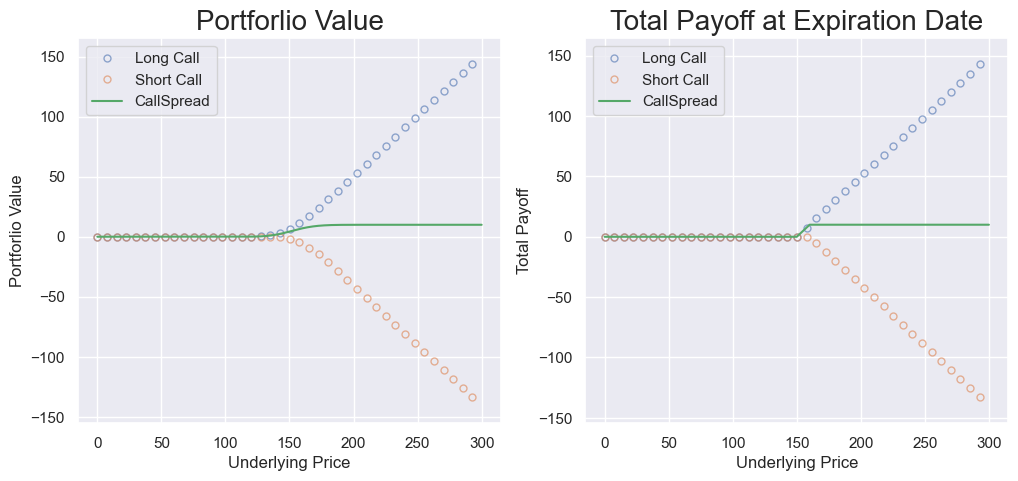

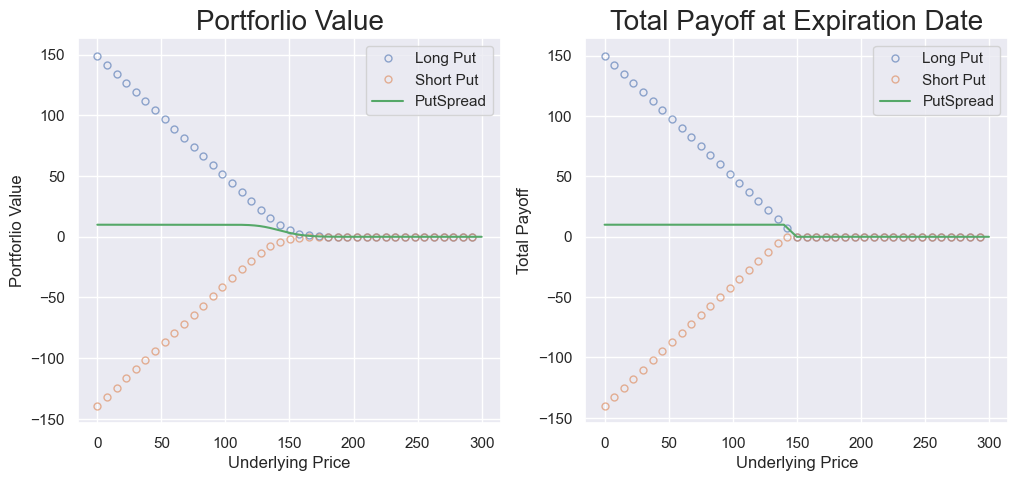

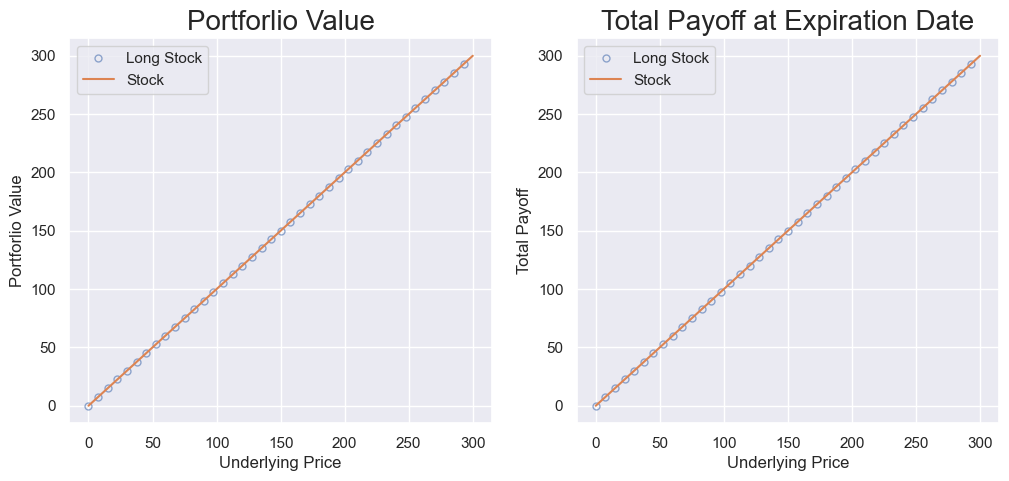

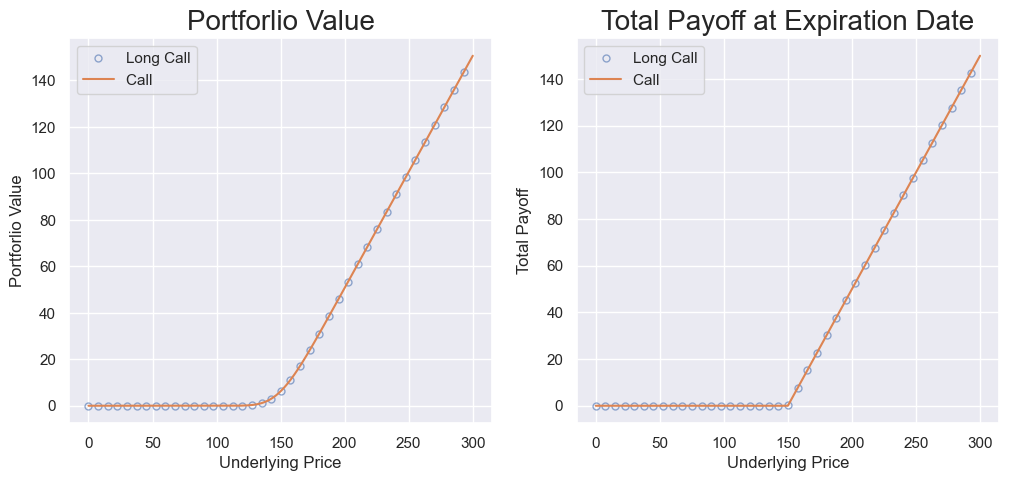

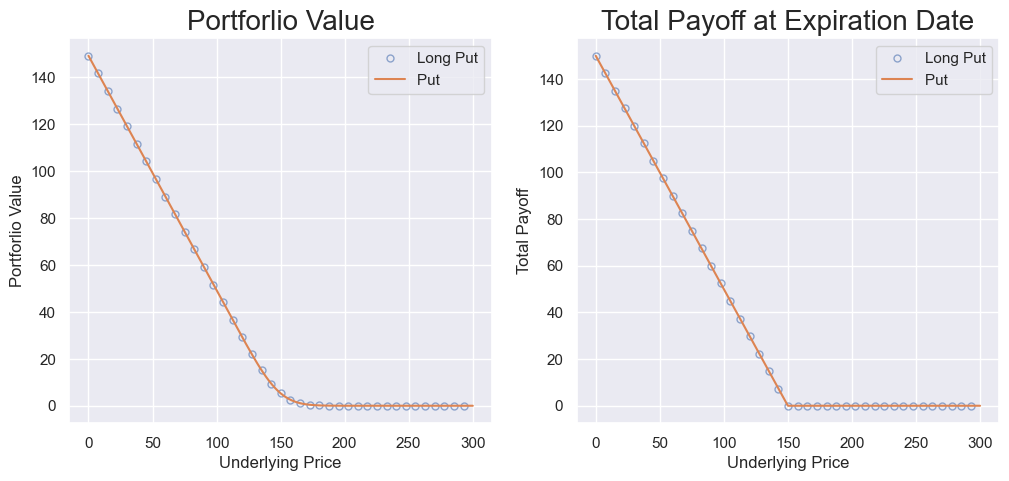

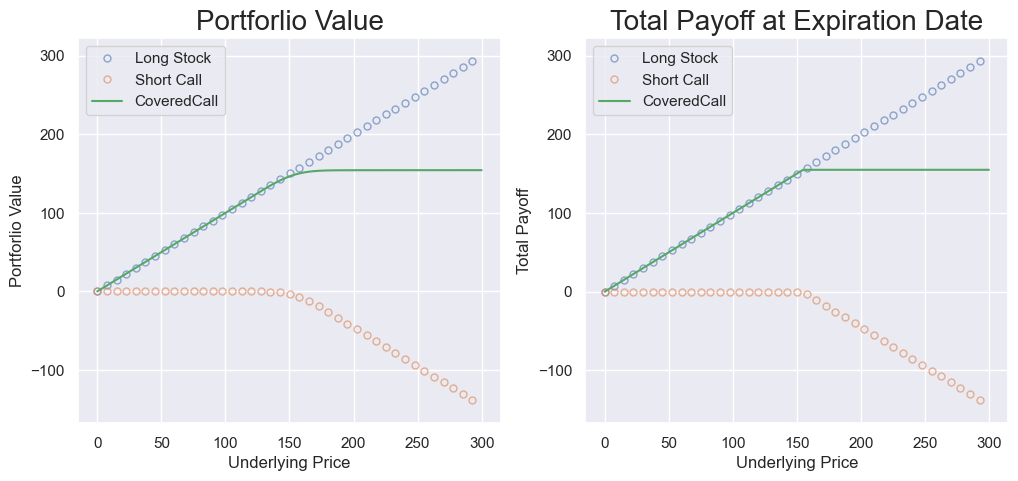

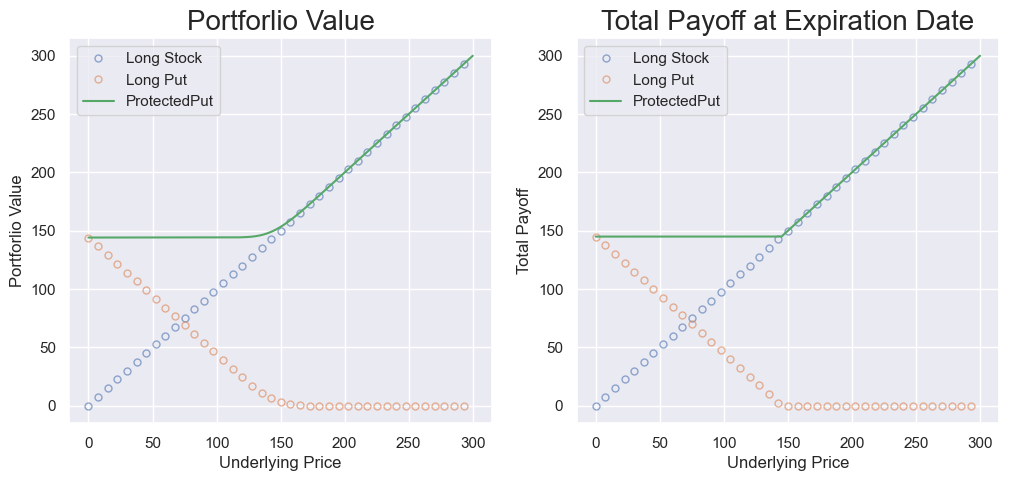

In [45]:
priceLowerBound=1e-10 # Lower bound of underlying price
priceUpBound=300 # Upper bound of underlying price
N=1000 # number of intervals in underlying price
prices=np.linspace(priceLowerBound,priceUpBound,N) # price intervals
strategies=df.Portfolio.unique()

for strategy in strategies:
    data=df.query("Portfolio == @strategy")
    positionValue=data.apply(gbsm_plus,prices=prices,axis=1)
    payoff=data.apply(calPayoff,prices=prices,axis=1)
    totalPortfolioValue=positionValue.sum()
    totalPayoff=payoff.sum()
    # plot
    n=len(positionValue.index)
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

    for i in range(n):
        data_i=data.iloc[i,:]
        # choose legend according to type and holding
        if data_i.Holding>0 and data_i.Type=='Option':
            legend="Long "+data_i.OptionType
        elif data_i.Holding<0 and data_i.Type=='Option':
            legend="Short "+data_i.OptionType
        elif data_i.Holding>0:
            legend="Long "+data_i.Type
        elif data_i.Holding<0:
            legend="Short "+data_i.Type
        # plot the figure of portfolio values
        ax1.plot(prices,positionValue.iloc[i],"o",alpha=0.6,mfc='none',label=legend,markevery=25,ms=5)
        # plot the figure of payoff
        ax2.plot(prices,payoff.iloc[i],"o",alpha=0.6,mfc='none',label=legend,markevery=25,ms=5)

    ax1.plot(prices,totalPortfolioValue,label=strategy)
    ax1.legend(loc='best')
    ax1.set_xlabel('Underlying Price')
    ax1.set_ylabel('Portforlio Value')
    ax1.set_title('Portforlio Value',{'fontsize':20})
    ax2.plot(prices,totalPayoff,label=strategy)
    ax2.legend(loc='best')
    ax2.set_xlabel('Underlying Price')
    ax2.set_ylabel('Total Payoff')
    ax2.set_title('Total Payoff at Expiration Date',{'fontsize':20})
    plt.savefig("./image/image_3/optionStrategy/{}.png".format(strategy),dpi=600, bbox_inches='tight')
    plt.show()
    

In [43]:
# Fit the AR1 Model and simulate the return 10 days ahead 
priceData=pd.read_csv('DailyPrices.csv',index_col='Date')
logReturn=return_calculate(priceData.AAPL,option="CONTINUOUS",rm_means=True)
# fit AR1 model
mod = sm.tsa.arima.ARIMA(logReturn.values, order=(1, 0, 0))
start_params = [0.5,0.1]
res = mod.fit_constrained({'const':0},start_params=start_params)
# current Price
currentPrice=151.03
# simulate price ten days later
simulatedPrice=[]
N=100000 # number of simulations

simulatedReturns=[]
for _ in range(N):
    simulatedReturn=res.simulate(nsimulations=10)
    simulatedReturns.append(simulatedReturn)
    tenDaysReturn=sum(simulatedReturn)
    simulatedPrice.append(currentPrice*np.exp(tenDaysReturn))
simulatedPrice=np.array(simulatedPrice)
simulatedReturns=np.array(simulatedReturns).flatten()

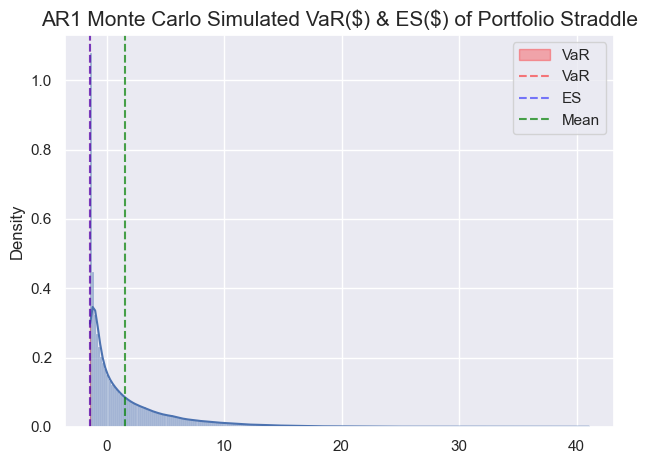

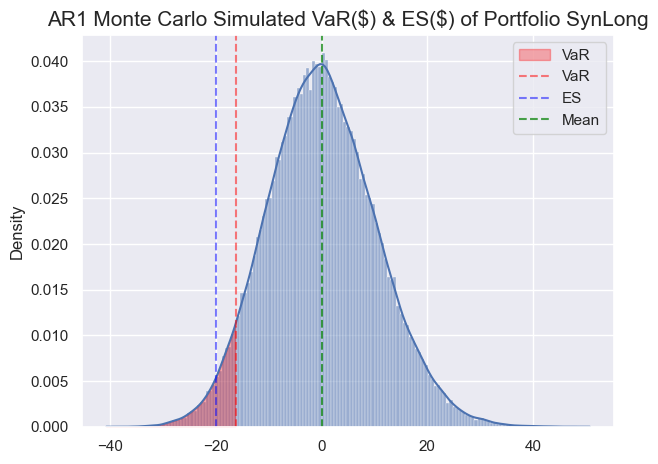

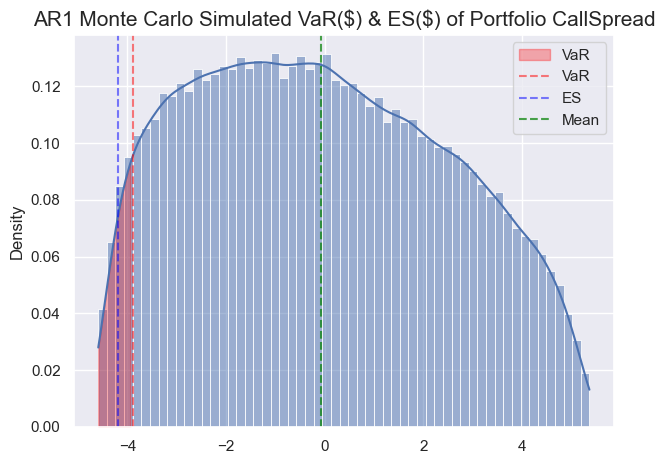

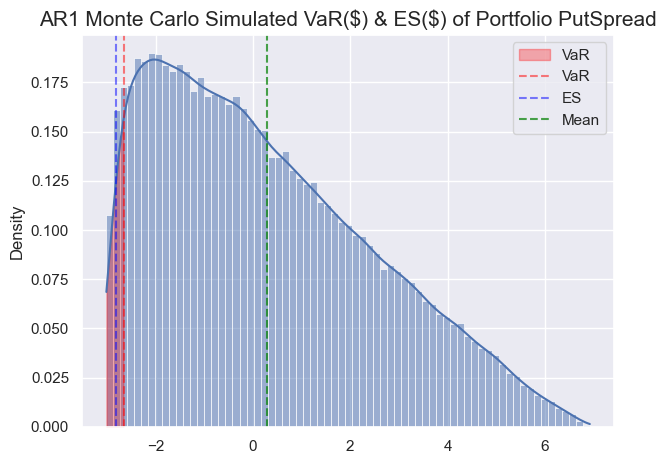

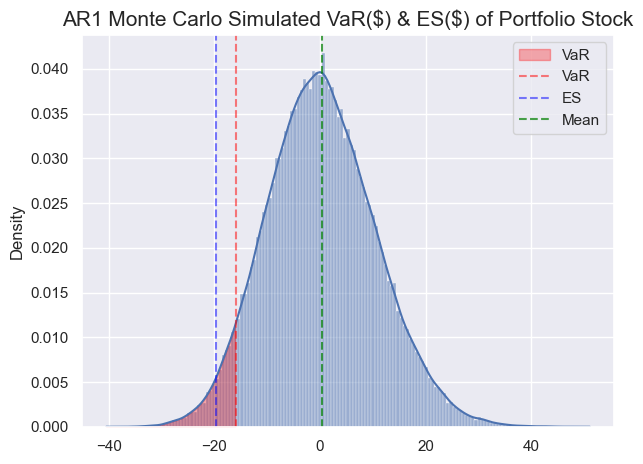

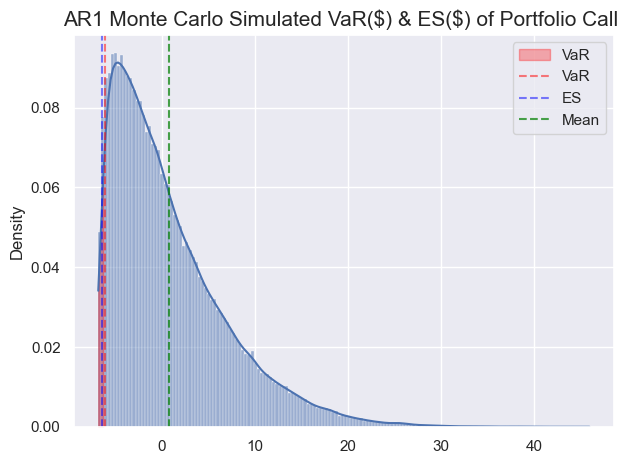

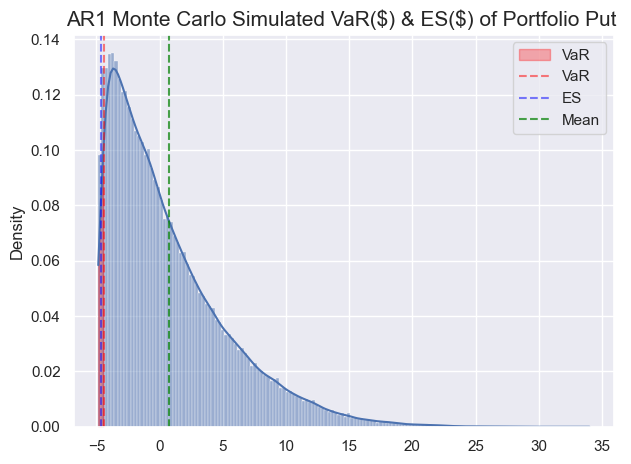

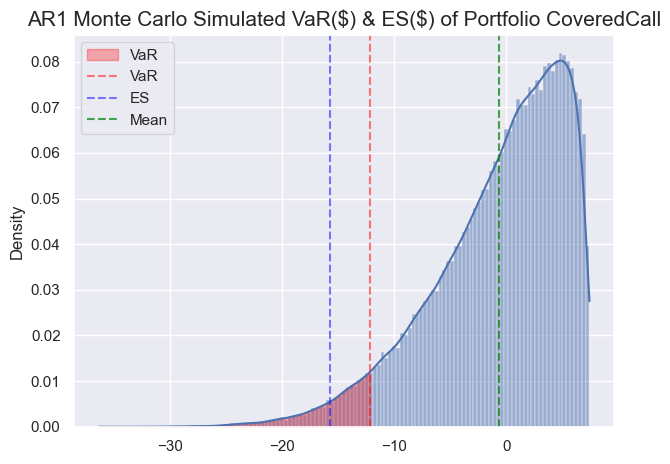

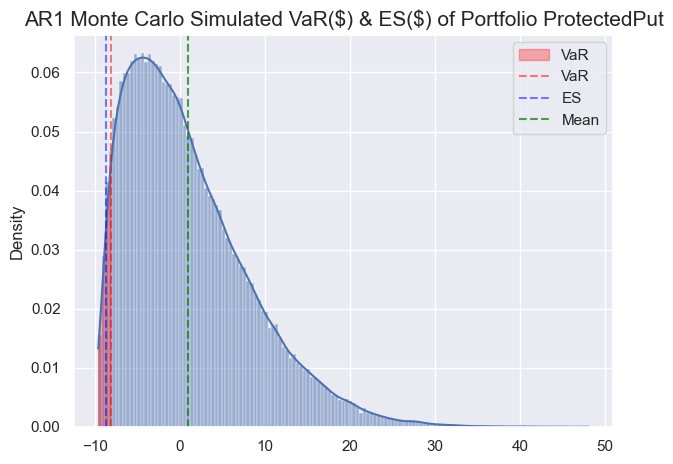

,Mean(Portfolio Value),Mean(Change),VaR,ES
Straddle,13.236627,1.586627,1.378317,1.387136
SynLong,2.050838,0.100838,16.24976,19.975054
CallSpread,4.519231,-0.070769,3.89146,4.181353
PutSpread,3.292349,0.282349,2.6562,2.811006
Stock,151.334622,0.304622,16.007244,19.710478
Call,7.643733,0.843733,6.039037,6.362422
Put,5.592895,0.742895,4.401389,4.601255
CoveredCall,146.323396,-0.656604,12.191148,15.780425
ProtectedPut,154.976053,0.936053,8.074428,8.681969


In [44]:
# pply those returns to the current AAPL price (above). Calculate Mean, VaR and ES
strategies=df.Portfolio.unique()
columns=['Mean(Portfolio Value)','Mean(Change)','VaR','ES']
ans=pd.DataFrame(index=strategies,columns=columns)
for idx,strategy in enumerate(strategies):
    data=df.query("Portfolio == @strategy")
    # Simulated Position Value
    positionValue=data.apply(gbsm_plus,prices=simulatedPrice,days=10,axis=1)
    # Initial Position Value
    iniValue=data.apply(gbsm_plus,prices=np.array([currentPrice]),axis=1)
    # Simulated Portfolio Value
    totalPortfolioValue=positionValue.sum()
    # Initial Portfolio Value
    iniValue=iniValue.sum()
    # Changed Portfolio Value
    valueChange=totalPortfolioValue-iniValue
    valueChange = np.array(valueChange)
    # calculate VaR and Expected Shortfall
    VaR_p = RiskMetrics.VaR_historical(valueChange,alpha=0.05)
    ES = RiskMetrics.ES_historical(valueChange,alpha=0.05)

    # insert Mean, VaR, ES to dateframe
    mean_var_es=[totalPortfolioValue.mean(),valueChange.mean(),VaR_p,ES]
    ans.loc[strategy]=mean_var_es

    # plot
    fig, ax = plt.subplots()
    sns.histplot(data=valueChange,kde=True,stat="density",ax=ax,label='')
    # Get the two lines from the axes to generate shading
    l = ax.lines[0]
    # Get the xy data from the lines so that we can shade
    x = l.get_xydata()[:,0]
    y = l.get_xydata()[:,1]
    ax.fill_between(x,y,where=x<-VaR_p,color="red", alpha=0.3,label='VaR') # fill VaR area
    ax.axvline(-VaR_p,color="red",alpha=0.5,linestyle='--',label='VaR') # plot the vertical line of VaR_p
    ax.axvline(-ES,color="blue",alpha=0.5,linestyle='--',label='ES') # plot the vertical line of ES
    ax.axvline(valueChange.mean(),color="green",alpha=0.7,linestyle='--',label='Mean') # plot the vertical line of mean
    ax.set_title("AR1 Monte Carlo Simulated VaR(\$) & ES(\$) of Portfolio {}".format(strategy),{'fontsize':15})
    ax.legend()
    fig.tight_layout()
    plt.savefig("./image/image_3/Simulation/{}.png".format(strategy),dpi=600, bbox_inches='tight')
    plt.show()

ans
    